<a href="https://colab.research.google.com/github/hrishikeshchavan99/Black-Friday-Dataset/blob/master/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Feature selection and dimensionality reduction using Principle component analysis(PCA)**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv')

Now, to check the missing values

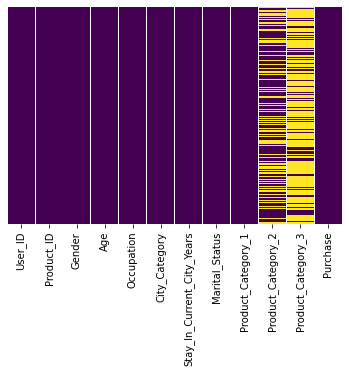

In [3]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [4]:
train.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

as we have only 30% data inside Product_Category_3 we will drop this coloumn

In [0]:
train.drop('Product_Category_3',axis=1,inplace=True)

In [6]:
train.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Purchase                           0
dtype: int64

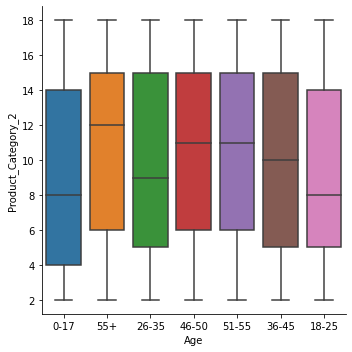

In [7]:
sns.catplot(y='Product_Category_2',x='Age',data=train,kind='box')

Product_Category_2 has different mean values for different age category.<br>
hence we will replace Product_Category_2 NAN values with appropriate mean values according to respective age category.

In [0]:
col=[train['Product_Category_2'],train['Age']]

In [0]:
def impute_2(col):
    age=col[1]
    product_Category_2=col[0]
    
    if pd.isnull(product_Category_2):
        if age=='0-17':
            return 8
        elif age=='55+':
            return 12
        elif age=='26-35':
            return 9
        elif age=='46-50':
            return 11
        elif age=='51-55':
            return 11
        elif age=='36-45':
            return 10
        else:
            return 8
    else:
        return product_Category_2

In [0]:
train['Product_Category_2']=train[['Product_Category_2','Age']].apply(impute_2,axis=1)

In [11]:
train.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Purchase                      0
dtype: int64

So we removed all null values

Now we will add 2 more columns in dataset discount and discount percentage using transform.<br>Both are determined from Max Price.

In [0]:
train['Discount'] = train.groupby('Product_ID')['Purchase'].transform('max') - train['Purchase']

In [0]:
train['Percent_Discount'] = (
        100 * (train['Purchase'] - train.groupby('Product_ID')['Purchase'].transform('max')) /
        train.groupby('Product_ID')['Purchase'].transform('max'))

In [14]:
train

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase,Discount,Percent_Discount
0,1000001,P00069042,F,0-17,10,A,2,0,3,8.0,8370,5346,-38.976378
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,15200,4501,-22.846556
2,1000001,P00087842,F,0-17,10,A,2,0,12,8.0,1422,354,-19.932432
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,1057,721,-40.551181
4,1000002,P00285442,M,55+,16,C,4+,0,8,12.0,7969,2104,-20.887521
...,...,...,...,...,...,...,...,...,...,...,...,...,...
550063,1006033,P00372445,M,51-55,13,B,1,1,20,11.0,368,245,-39.967374
550064,1006035,P00375436,F,26-35,1,C,3,0,20,9.0,371,242,-39.477977
550065,1006036,P00375436,F,26-35,15,B,4+,1,20,9.0,137,476,-77.650897
550066,1006038,P00375436,F,55+,1,C,2,0,20,12.0,365,248,-40.456770


Now, for dimensionality reduction we need to determine which categories are actually contributing to varience

In [15]:
#Calculate the unique products being sold by Product Category
train['Product_ID'].nunique()

3631

We will first see the impact of top selling products 

In [0]:
#Take top 25 selling prodects into consideration.
top_purchases = train.groupby('Product_ID').sum().reset_index().nlargest(25, columns='Purchase')

In [0]:
#Also Find the top 25 discounted products by Product IDs
top_discounted = train.groupby('Product_ID').sum().reset_index().nlargest(25, columns='Discount')

Now plot them against product ID to check its impact

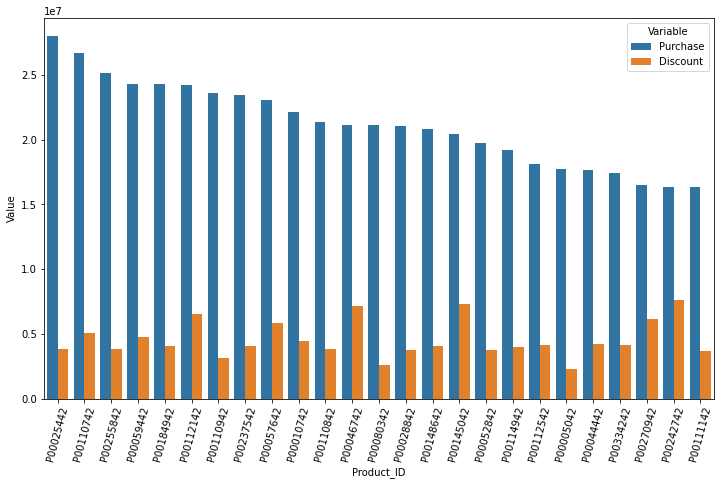

In [18]:
plot_1 = (        
        top_purchases
        .groupby('Product_ID')
        .agg({'Purchase': 'sum', 'Discount': 'sum'})
        .sort_values(by = 'Purchase', ascending=False)
        .stack().reset_index()
        .rename(columns={'level_1': 'Variable', 0: 'Value'})
        )

plt.figure(figsize=(12, 7))
plt.xticks(rotation=75)
sns.barplot(x='Product_ID', y='Value', hue='Variable', data=plot_1)

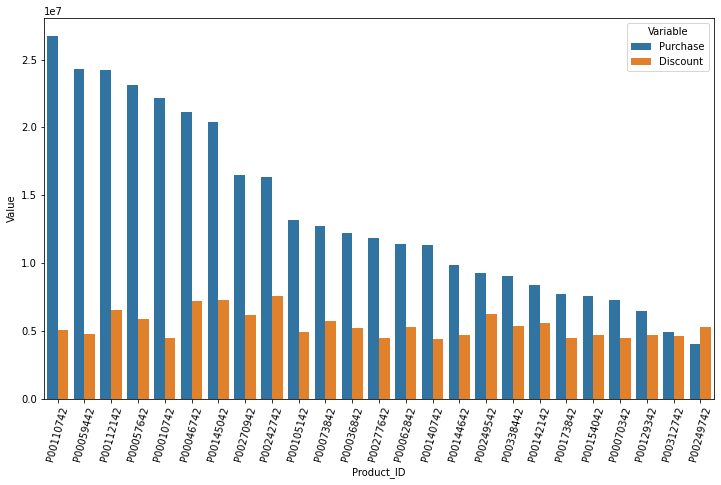

In [19]:
plot_2 = (        
        top_discounted
        .groupby('Product_ID')
        .agg({'Purchase': 'sum', 'Discount': 'sum'})
        .sort_values(by = 'Purchase', ascending=False)
        .stack().reset_index()
        .rename(columns={'level_1': 'Variable', 0: 'Value'})
        )

plt.figure(figsize=(12, 7))
plt.xticks(rotation=75)
sns.barplot(x='Product_ID', y='Value', hue='Variable', data=plot_2)

From this, we can see that there is no regular pattern(no significant reductions or increments) for discount. So we will focus only on top sells.

In [0]:
keys_purchases = list(top_purchases['Product_ID'].values)

In [0]:
#create a copy of dataset consisting of rows of product IDs with key purchases
temp = train[train['Product_ID'].isin(keys_purchases)].copy()

To perform PCA, we need to input features.<br> For that, convert categorical features into dummy variables in copy of dataset.

In [22]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase,Discount,Percent_Discount
0,1000001,P00069042,F,0-17,10,A,2,0,3,8.0,8370,5346,-38.976378
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,15200,4501,-22.846556
2,1000001,P00087842,F,0-17,10,A,2,0,12,8.0,1422,354,-19.932432
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,1057,721,-40.551181
4,1000002,P00285442,M,55+,16,C,4+,0,8,12.0,7969,2104,-20.887521


In [23]:
temp.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase,Discount,Percent_Discount
6,1000004,P00184942,M,46-50,7,B,2,1,1,8.0,19215,492,-2.496575
13,1000005,P00145042,M,26-35,20,A,1,1,1,2.0,15665,4040,-20.502411
41,1000010,P00111142,F,36-45,1,B,4+,1,1,15.0,18963,743,-3.770425
44,1000010,P00148642,F,36-45,1,B,4+,1,6,10.0,12642,8048,-38.898018
48,1000011,P00110842,F,26-35,1,C,1,0,1,2.0,19327,381,-1.933225


Before converting to dummy variable, we need all values in string.<br>Since Occupation, Product Catogery 1 and 2 are integers, we first convert them into strings.

In [0]:
temp['Occupation'] = temp['Occupation'].apply(lambda x: 'j' + str(x))
temp['Product_Category_1'] = temp['Product_Category_1'].apply(lambda x: 'p' + str(x))
temp['Product_Category_2'] = temp['Product_Category_2'].apply(lambda x: 'p' + str(x))

In [0]:
#now add dummy variables for Product_ID, Gender, Age, and Stay_In_Current_City using pandas
Product_ID_2 = pd.get_dummies(temp['Product_ID'],drop_first=True)
Gender2 = pd.get_dummies(temp['Gender'],drop_first=True)
Age2 = pd.get_dummies(temp['Age'],drop_first=True)
Stay_years2 = pd.get_dummies(temp['Stay_In_Current_City_Years'],drop_first=True)
Occupation2 = pd.get_dummies(temp['Occupation'],drop_first=True)
Product_cat1 = pd.get_dummies(temp['Product_Category_1'],drop_first=True)
Product_cat2 = pd.get_dummies(temp['Product_Category_2'],drop_first=True)

In [26]:
temp.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase,Discount,Percent_Discount
6,1000004,P00184942,M,46-50,j7,B,2,1,p1,p8.0,19215,492,-2.496575
13,1000005,P00145042,M,26-35,j20,A,1,1,p1,p2.0,15665,4040,-20.502411
41,1000010,P00111142,F,36-45,j1,B,4+,1,p1,p15.0,18963,743,-3.770425
44,1000010,P00148642,F,36-45,j1,B,4+,1,p6,p10.0,12642,8048,-38.898018
48,1000011,P00110842,F,26-35,j1,C,1,0,p1,p2.0,19327,381,-1.933225


In [27]:
temp.shape

(32167, 13)

In [0]:
#remove original columns from copy of dataset i.e. temp
temp.drop(['Product_ID','Gender','Age','Stay_In_Current_City_Years', 'Occupation','Product_Category_1', 'Product_Category_2'],axis=1,inplace=True)

In [0]:
#now add new colums 
temp = pd.concat([temp, Product_ID_2,Gender2,Age2,Stay_years2, Occupation2, Product_cat1, Product_cat2],axis=1)

In [30]:
temp.shape

(32167, 72)

Now our dataframe is ready for PCA analysis with 72 degrees of freedom

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [32]:
temp.head()

,User_ID,City_Category,Marital_Status,Purchase,Discount,Percent_Discount,P00010742,P00025442,P00028842,P00044442,P00046742,P00052842,P00057642,P00059442,P00080342,P00110742,P00110842,P00110942,P00111142,P00112142,P00112542,P00114942,P00145042,P00148642,P00184942,P00237542,P00242742,P00255842,P00270942,P00334242,M,18-25,26-35,36-45,46-50,51-55,55+,1,2,3,4+,j1,j10,j11,j12,j13,j14,j15,j16,j17,j18,j19,j2,j20,j3,j4,j5,j6,j7,j8,j9,p10,p16,p6,p11.0,p12.0,p15.0,p16.0,p2.0,p6.0,p8.0,p9.0
6,1000004,B,1,19215,492,-2.496575,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
13,1000005,A,1,15665,4040,-20.502411,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
41,1000010,B,1,18963,743,-3.770425,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
44,1000010,B,1,12642,8048,-38.898018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
48,1000011,C,0,19327,381,-1.933225,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
